In [42]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from utils.metrics import evaluate


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [2]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)

split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('datasets/training.csv')
df_test.to_csv('datasets/test.csv')

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [3]:
# Also add the naive mean average value
mean = df_training.pollution_today.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test.pollution_today, df_test.pollution_yesterday)
predictionsDict['Yesterdays value'] = df_test.pollution_yesterday.values

## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [4]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SES'] = yhat.values

  3%|▎         | 10/364 [00:00<00:03, 98.13it/s]

100%|██████████| 364/364 [00:03<00:00, 92.90it/s] 


### Holt Winter’s Exponential Smoothing (HWES)

[HWES](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) or also known as triple exponential smoothing

In [5]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 364/364 [00:04<00:00, 87.70it/s]


### Autoregression (AutoReg)
The autoregression (AutoReg) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AutoReg (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).


In [6]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = AutoReg(temp_train.pollution_today, lags=1)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 364/364 [00:01<00:00, 259.49it/s]


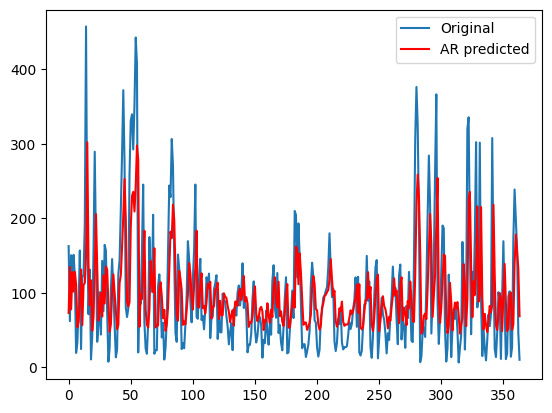

In [7]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

### ARIMA

In [8]:


# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(0, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 364/364 [00:12<00:00, 29.75it/s]


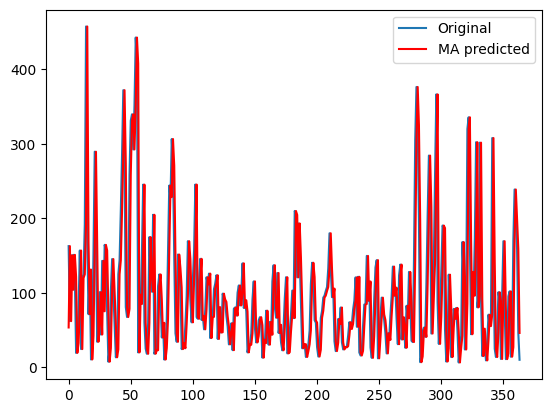

In [9]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()

### ARIMA




In [10]:
# ARMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1, 1, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 364/364 [03:03<00:00,  1.98it/s]


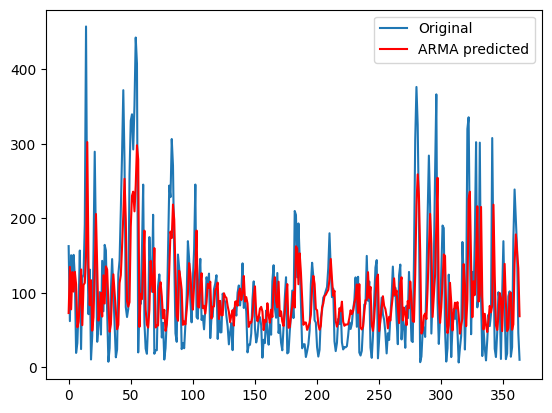

In [11]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [12]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:28<00:00, 12.73it/s]


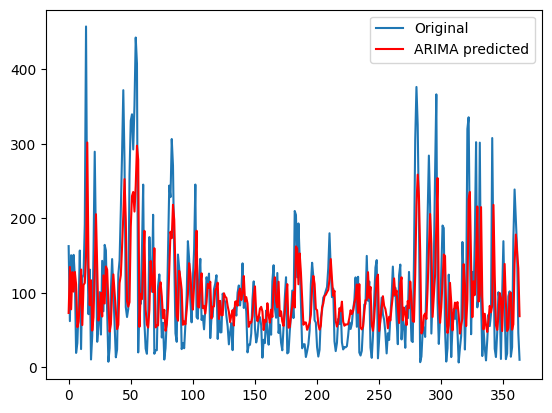

In [13]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

#### Auto ARIMA

In [14]:
# building the model

autoModel = pm.auto_arima(df_training.pollution_today, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18232.724, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16461.265, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17191.945, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16462.630, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16462.086, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16455.385, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16266.588, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16869.411, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16217.321, Time=0.60 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16711.266, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [15]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.pollution_today, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 364/364 [01:23<00:00,  4.37it/s]


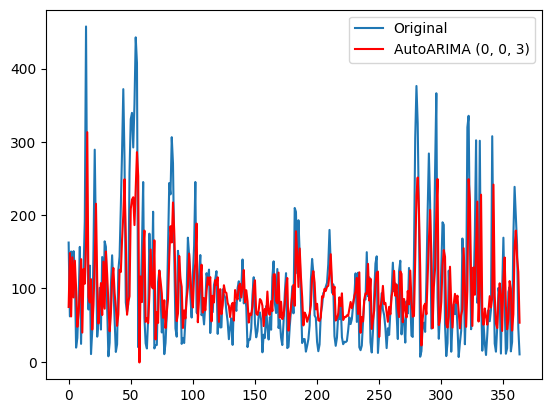

In [16]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [17]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.pollution_today, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 364/364 [00:13<00:00, 26.90it/s]


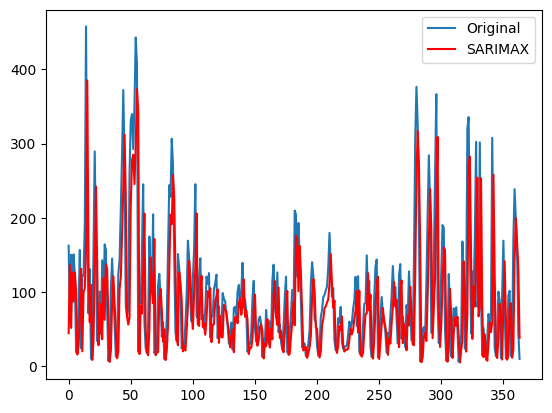

In [18]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [19]:
# building the model
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution_today)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16199.933, Time=2.96 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16788.406, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16229.161, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16265.917, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18232.724, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16200.349, Time=0.63 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16200.355, Time=0.74 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16203.879, Time=2.04 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16203.861, Time=2.17 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16198.453, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16196.487, Time=0.96 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16198.378, Time=1.22 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16198.371, Time=1.36 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16200.253, Time=0.99 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [20]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

100%|██████████| 364/364 [00:30<00:00, 11.81it/s]


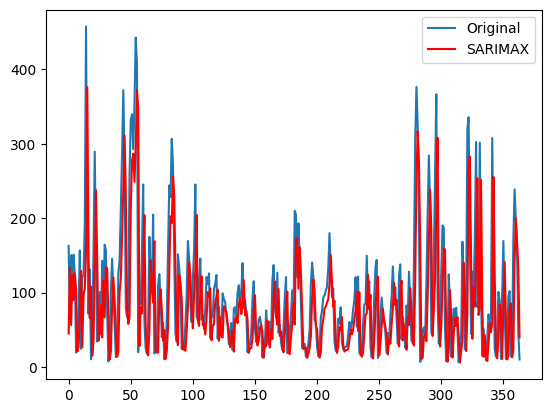

In [21]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

## Multivariate time series forecasting

In [22]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [23]:
X_train_df, y_train = create_time_features(
    df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

### Linear models

#### Bayesian regression

In [24]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['BayesianRidge'] = yhat

#### Lasso

In [25]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lasso'] = yhat

### Tree models

#### Randomforest

In [26]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Randomforest'] = yhat

#### XGBoost

In [27]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['XGBoost'] = yhat

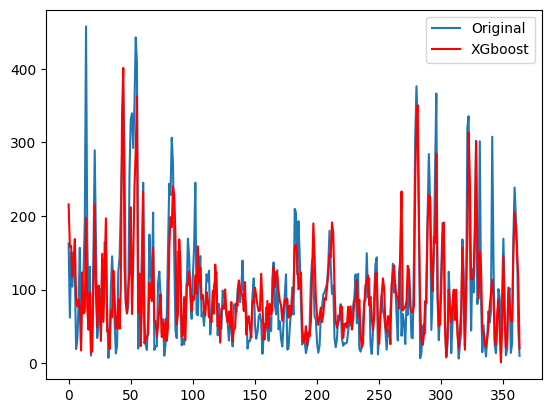

In [28]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [29]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Lightgbm'] = yhat

### Support vector machines

Explain multiple kernels balbla

In [30]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF'] = yhat

### Nearest neighbors

In [31]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['Kneighbors'] = yhat

# Appendix

## Hyperparameter optimization

We have seen models with really low amount of parameters (Auto regression models,Linear models) or with crazy ammount (Trees,Prophet). Some models are more robust to different data types/shapes and dont need any hyperparameter optimization but some other can give you poor results if the parameters are not tunned, we can tune the model parameters to better fit our dataset properties. We can do this manually with pure knowledge about the model but this becames really hard when the model contains a lot of different parameters, this is when hyperparameter optimization comes handy.

Hyperparameter optimization is trying to find the best parameters in an automatic way. We present two methods that are used frequently:

* **Grid search** Brute force method to try all different possible combinations of parameters. Will always find the best combination
* **Bayesian processes** "Brute" force method, optimizes parameter search by using gausian processes to model each parameter distribution and don't go over all the possible values. Really nice library for python https://github.com/fmfn/BayesianOptimization, this method will not always find the best combination of parameters

We provide 1 example for each method

### Grid search - SVM

With grid search we can use the handy sklearn implementation

In [32]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test.pollution_today, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [33]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is 16.202019315984874% better than the SVM with default parameters


### Bayesian processes - Xgboost

In [36]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
my_pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=my_pbounds,
    random_state=1,
)

In [45]:
optimizer.set_gp_params(alpha=1e-5, n_restarts_optimizer=2)

In [46]:
utility = UtilityFunction(kind="ucb", kappa=2.576, xi=0.0)

In [54]:
optimizer.maximize(
    init_points=3,
    n_iter=15,
    acquisition_function=utility
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 15        | -0.5117   | 4.228     | 2.242     | 7.555     | 4.2e+03   |
| 16        | -0.463    | 3.599     | 2.608     | 7.31      | 5.197e+03 |
| 17        | -0.5555   | 14.34     | 2.76      | 9.227     | 1.461e+03 |
| 18        | -0.5561   | 14.09     | 2.495     | 7.784     | 5.274e+03 |
| 19        | -0.4627   | 3.813     | 2.735     | 8.011     | 3.006e+03 |
| 20        | -0.512    | 4.367     | 1.476     | 6.312     | 5.199e+03 |
| 21        | -0.4626   | 3.127     | 2.529     | 7.642     | 3.007e+03 |
| 22        | -0.5086   | 4.834     | 3.713     | 5.364     | 5.198e+03 |
| 23        | -0.5314   | 5.713     | 2.597     | 8.134     | 3.008e+03 |
| 24        | -0.4612   | 3.167     | 3.396     | 6.379     | 3.004e+03 |
| 25        | -0.5286   | 5.656     | 3.314     | 5.023     | 3.006e+03 |
| 26        | -0.4614   | 3.859     | 

In [55]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [56]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 10.40887204263412% better than the Randomforest with default parameters


In [57]:

with open('results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)